# Pip Installs

In [2]:
!pip install boruta==0.3

In [3]:
!pip install xgboost==2.0.0

In [4]:
!pip install optuna==3.3.0

In [5]:
!pip install shap==0.42.1

# In This Notebook

We'll score the unlabeled dataset and create a policy where we don't deny more than 300 customers a day.

Normally, I'd try to understand with the business teams exactly what metric they are trying to maximize, what are the business constraints when taking decisions and try to create metrics regarding how much money we would save by denying said transactions, but since I have no way of knowing exactly how much it costs when a fraud occurs and how much money a transaction gives the company, in an almost ludical way I'll assume there is a team with the capacity of evaluating only 300 transactions a day and I need to choose which ones they'll evaluate.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier
import optuna
from optuna import Trial, visualization

from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import ks_2samp
import shap

np.random.seed(3108)
# I'm not iterating over the seed, this is just my birthdate

# Transformers

Even though it would be very simple separating these transformers in an aux file, and the code being duplicated hurts the DRY-code principle, in notebook 05 I wanted to show how these transformers are created so I don't see a reason to do that in the case scenario.

In [7]:
class SeasonalCols(BaseEstimator, TransformerMixin):
    """
    I'll create a value that indicates if the transaction ocurred too late 
    at night or during the weekend. First I was thinking about creating
    flags that indicated if the transaction was on the weekend or during
    the night but to be honest I see no reason to not use the full value.
    
    Here we could create stuff like "month" or "day of month" but since
    we don't have much of a historic dataframe I'll keep myself to just
    the hour and the day-of-week. 
    """
    def __init__(self, date_col):
        self.date_col = date_col
        
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        X_[self.date_col] = pd.to_datetime(X_[self.date_col])
        X_[self.date_col+'_weekday'] = pd.to_datetime(X_[self.date_col]).dt.weekday
        X_[self.date_col+'_hour'] = pd.to_datetime(X_[self.date_col]).dt.hour
        print("DayOfWeek and Hour Variables Created!")
        
        return X_

class DatesToDateDiff(BaseEstimator, TransformerMixin):
    """
    This will help us transform dates to numbers, by taking how many days 
    passed between one event and the other one.
    """
    def __init__(self, date_cols):
        self.date_cols = date_cols
        
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        date_cols = self.date_cols.copy()
        
        for date_col in date_cols:
            X_[date_col] = pd.to_datetime(X_[date_col])
            
        while len(date_cols) > 1:
            base_date = date_cols.pop()
            for date_col in date_cols:
                col_name = 'diff_{}_{}'.format(base_date, date_col)
                X_[col_name] = (X_[base_date] - X_[date_col])/np.timedelta64(1, 'D')
            
            print("DateDiffs regarding {} timestamp created!".format(base_date))
                
        X_.drop(columns=self.date_cols, inplace=True)
        return X_

class OneHotEncoder(BaseEstimator, TransformerMixin):
    """
    With this personalized OneHotEncoder, we'll map every category that has more than x%
    presence on the dataset and, if it has, create a flag regarding it. If not, we could
    call it "others" and group them, but I'll just assume it's the "leave one out" class 
    of the encoder.
    """
    def __init__(self, cat_variable, minor_category=0.05):
        self.cat_variable = cat_variable
        self.minor_category = minor_category
        
    def fit(self, X, y = None):
        X_ = X.copy()
        mapper = dict(X_[self.cat_variable].fillna('NULL').value_counts(normalize=True))
        mapper = [key for key, val in mapper.items() if val > self.minor_category]
        self.mapper = mapper
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        
        for category in self.mapper:
            cat_flag = '{}_{}'.format(self.cat_variable, category)
            X_[cat_flag] = 0
            X_.loc[X_[self.cat_variable].fillna('NULL') == category, cat_flag] = 1
        X_.drop(columns=[self.cat_variable], inplace=True)
        
        print("OneHotEncode for var {} Done!".format(self.cat_variable))
        return X_

class FillNulls(BaseEstimator, TransformerMixin):
    """
    Fill nulls with Special Value. Since I intend to use tree based algorithms, 
    I'll fill nulls with -999 as a special value.
    """
    def __init__(self, special_value=-999):
        self.special_value = special_value
        
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        X_ = X_.fillna(self.special_value)
        print("Nulls Filled With {}!".format(self.special_value))
        return X_

class BorutaAdjusted(BaseEstimator, TransformerMixin):
    """
    Small adjusts on BorutaPy just so we can add it to the sklearn pipeline.
    """
    def __init__(self, feat_selector):
        self.feat_selector = feat_selector
        
        
    def fit(self, X, y):
        X_ = X.copy()
        y_ = y.copy()
        
        np.int = int
        np.float = float
        np.bool = bool
        
        self.feat_selector.fit(X_.values, y_.values)
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        boruta_decisions = dict(zip(X_.columns, self.feat_selector.support_))
        choosen_cols = [key for key, value in boruta_decisions.items() if value]
        
        vars_removed = X.shape[1] - len(choosen_cols)
        
        print('{} vars removed due to low impact by the Boruta Step!'.format(vars_removed))
        
        return X_[choosen_cols]

class XGBoostTransformer(BaseEstimator, TransformerMixin):
    """
    Small adjusts on XGBoost just so we can add it to the sklearn pipeline.
    I also would like to keep the explainer cols so...
    """
    def __init__(self, params):
        self.params = params
        self.model = XGBClassifier(**params)
        
        
    def fit(self, X, y):
        X_ = X.copy()
        y_ = y.copy()
        
        self.model.fit(X_.values, y_.values)
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        preds = self.model.predict_proba(X_)[:, 1]
        X_['preds'] = preds
        print("Finished Scoring the Model!")
        return X_

# Loading the Pipeline

In [8]:
import pickle

with open(r"files/best_model.pickle", "rb") as input_file:
    pipe = pickle.load(input_file)

# Reading Unlabeled Data and Applying the Pipe

In [9]:
# Reading the treated dataset

ut = pd.read_csv('files/unlabeled_transactions_enriched2.csv', sep=';')

# Caught a typo on 03_Joins, will redo a step here just so I don't have to rerrun everything
us_cols = ['us_inserted_at']
ut.loc[pd.to_datetime(ut['us_inserted_at']) > pd.to_datetime(ut['processed_at']), us_cols] = None

In [10]:
X = ut.drop(columns=['treated_user_id'])

In [11]:
import time
start_time = time.time()

X_final = pipe.transform(X)

print("The whole scoring process took {:.0f} seconds to run.".format(time.time() - start_time))

DayOfWeek and Hour Variables Created!
OneHotEncode for var ac_owner_type Done!
OneHotEncode for var omot_value Done!
OneHotEncode for var age_range Done!
DateDiffs regarding us_inserted_at timestamp created!
DateDiffs regarding um_updated_at timestamp created!
DateDiffs regarding um_inserted_at timestamp created!
DateDiffs regarding og_inserted_at timestamp created!
DateDiffs regarding omot_updated_at timestamp created!
DateDiffs regarding omot_inserted_at timestamp created!
DateDiffs regarding ac_inserted_at timestamp created!
Nulls Filled With -999!
9 vars removed due to low impact by the Boruta Step!
Finished Scoring the Model!
The whole scoring process took 35 seconds to run.


In [12]:
X_final['processed_at'] = pd.to_datetime(ut['processed_at'])

# Policy Development

I'll iterate over possible cut values, where I 

In [13]:
X_final['date'] = X_final['processed_at'].dt.date

In [14]:
X_final_ = X_final.copy()
results = {}

for i in range(3500, 5000, 20):
    if i % 500 == 0:
        print(i)
        
    i = i/10000
    X_final_['denied'] = X_final_['preds'] > i
    
    deny_q90 = X_final_.groupby('date').denied.sum().quantile(0.9)
    deny_q50 = X_final_.groupby('date').denied.sum().quantile(0.5)
    deny_mean = X_final_.groupby('date').denied.sum().mean()
    
    results.update({i: {'deny_mean': deny_mean, 'deny_q50': deny_q50, 'deny_q90': deny_q90}})

3500
4000
4500


In [15]:
results = pd.DataFrame.from_dict(results, orient='index')

In [16]:
results.reset_index(inplace=True)

In the graph below, I've plotted how many people would be sent to further analysis if we've cut every transaction above a certain threshold. We can see that using a score of .41 for this threshold will make about 90% of the days have no more than 300 cuts, with a mean of about 140 transactions denied daily and an median of 130 daily transactions denied.

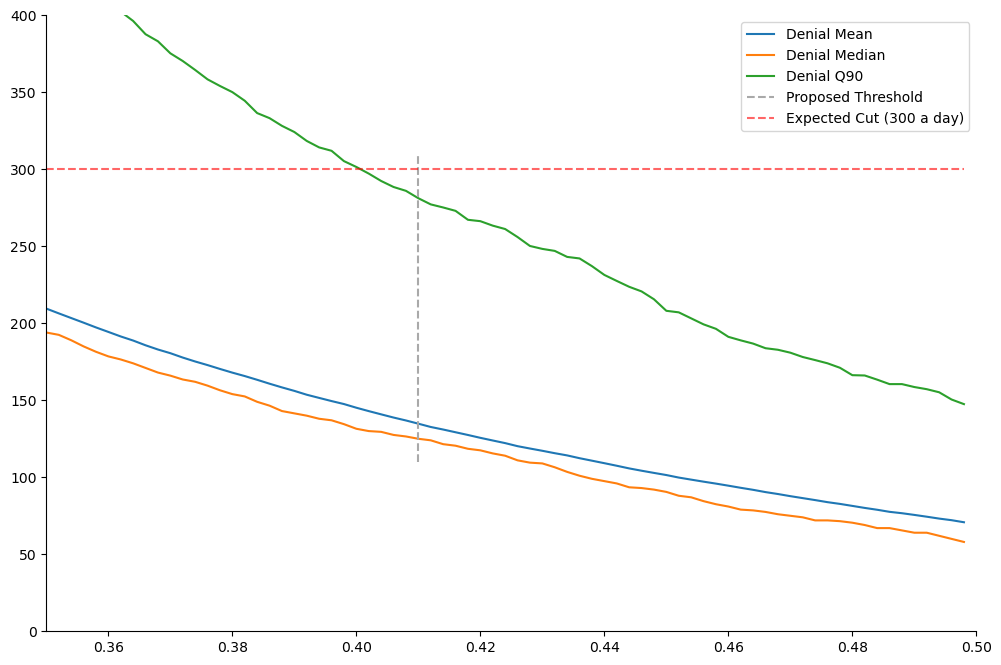

In [17]:
fig = plt.figure(figsize=(12, 8))

plt.plot(results['index'], results['deny_mean'], label='Denial Mean')
plt.plot(results['index'], results['deny_q50'], label='Denial Median')
plt.plot(results['index'], results['deny_q90'], label='Denial Q90')
plt.plot([0.41, 0.41], [110, 310], '--', color='darkgrey', label='Proposed Threshold')
plt.plot(results['index'], [300 for i in range(results.shape[0])], '--', color='red', alpha=0.6, label='Expected Cut (300 a day)')

plt.legend(loc='best')

plt.xlim([0.35,0.5])
plt.ylim([0,400])

sns.despine()

In [18]:
results[results['deny_q90'] < 300].head()

,index,deny_mean,deny_q50,deny_q90
26,0.402,142.9625,130.0,297.2
27,0.404,140.8625,129.5,292.4
28,0.406,138.7875,127.5,288.5
29,0.408,136.8875,126.5,286.0
30,0.410,134.8000,125.0,281.2


In [19]:
X_final['denied'] = X_final['preds'] > 0.41

In [20]:
denials = X_final.groupby('date').agg(
    avg_denials=pd.NamedAgg('denied', 'mean'),
    total_denials=pd.NamedAgg('denied', 'sum'),
).reset_index()

In [21]:
denials.head(2)

,date,avg_denials,total_denials
0,2018-07-15,0.000000,0
1,2018-07-16,0.004725,476


In [22]:
denials.max()

date             2018-10-17
avg_denials        0.008262
total_denials          1001
dtype: object

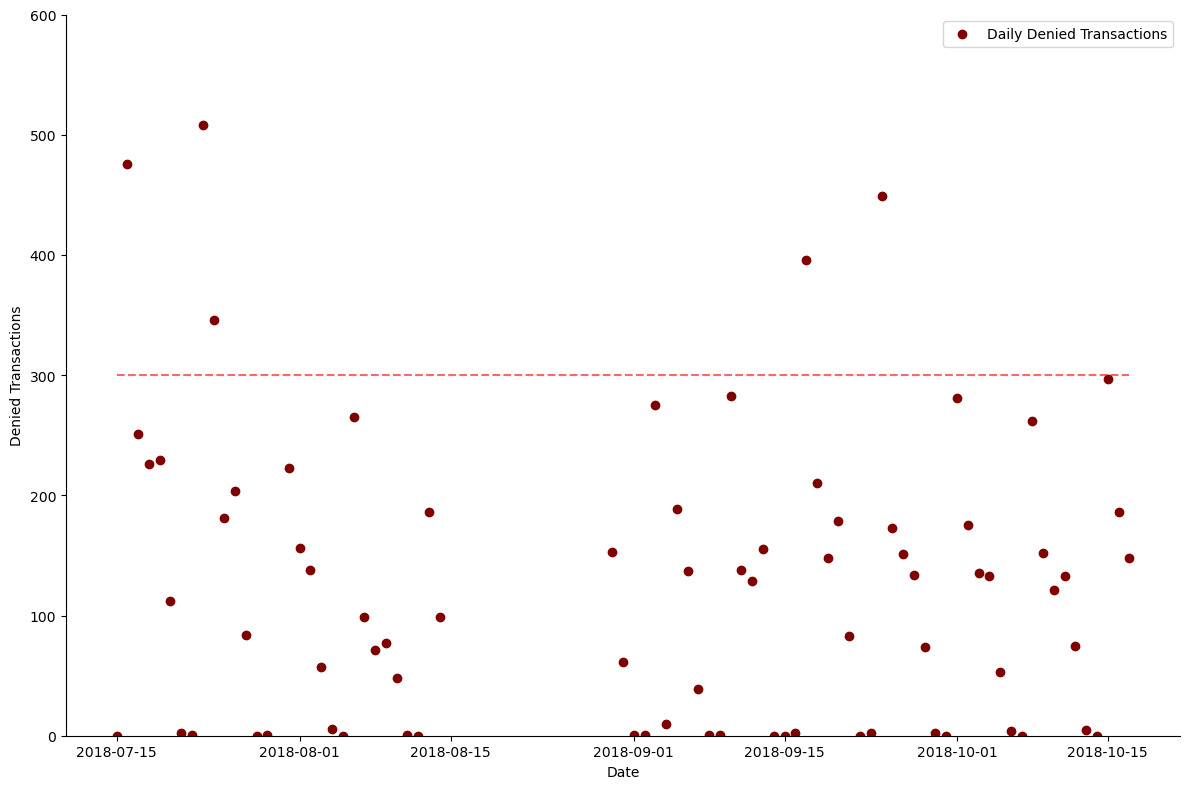

In [23]:
fig = plt.figure(figsize=(12,8))

plt.xlabel('Date')
plt.ylabel('Denied Transactions', )
plt.scatter(pd.to_datetime(denials['date']), denials['total_denials'], color='#800000', label='Daily Denied Transactions')
plt.plot(pd.to_datetime(denials['date']),  [300 for i in range(denials.shape[0])], '--', color='red', alpha=0.6, label='_Expected Cut (300 a day)')

sns.despine()
plt.legend(loc='best')

plt.ylim([0, 600])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

This leaves us with a simple question: whats the fraud rate of the public with a score of more than 0.41?

Even though I'm using the training set to check here, this could give us a great insight on the subject:

In [24]:
lt = pd.read_csv('files/labeled_transactions_enriched2.csv', sep=';')

# Caught a typo on 03_Joins, will redo a step here just so I don't have to rerrun everything
us_cols = ['us_inserted_at']
lt.loc[pd.to_datetime(lt['us_inserted_at']) > pd.to_datetime(lt['processed_at']), us_cols] = None

X_train = lt.drop(columns=['treated_user_id', 'is_fraud'])
y_train = lt['is_fraud'].replace('True', '1').astype(int)

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


In [25]:
start_time = time.time()

X_train = pipe.transform(X_train)

print("The whole scoring process took {:.0f} seconds to run.".format(time.time() - start_time))

DayOfWeek and Hour Variables Created!
OneHotEncode for var ac_owner_type Done!
OneHotEncode for var omot_value Done!
OneHotEncode for var age_range Done!
DateDiffs regarding us_inserted_at timestamp created!
DateDiffs regarding um_updated_at timestamp created!
DateDiffs regarding um_inserted_at timestamp created!
DateDiffs regarding og_inserted_at timestamp created!
DateDiffs regarding omot_updated_at timestamp created!
DateDiffs regarding omot_inserted_at timestamp created!
DateDiffs regarding ac_inserted_at timestamp created!
Nulls Filled With -999!
9 vars removed due to low impact by the Boruta Step!
Finished Scoring the Model!
The whole scoring process took 7 seconds to run.


In [26]:
X_train['denied'] = X_train['preds'].apply(lambda x: 'FurtherAnalysis' if x > 0.41 else 'GreenFlag')
X_train['y_true'] = y_train

denial_rate = X_train.groupby('denied').y_true.mean()

In [27]:
denial_rate

denied
FurtherAnalysis    0.175798
GreenFlag          0.000786
Name: y_true, dtype: float64

In [28]:
denial_rate.max()/denial_rate.min()

223.66181482278662

Having more than 1 in 6 chance of being a fraudulant transaction, and more than 200x riskier than the unflagged group, this policy could really help to relieve the analysis team and avoid fraudulent transactions to occur.